## Import Libraries

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
from typing import Dict, List, Any, Set, Tuple, Union, Optional
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
# from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

## Functions

### Statistical Analysis

In [118]:
from scipy.stats import shapiro, normaltest

def detect_normality(data: pd.Series,alpha:float=0.05, soft: bool = False, display_info: bool = False) -> str:
    
    info: Dict[str, float] = {}
    data = data.dropna()
    
    if len(data) < 8:
        return 'Test failed (insufficient data)'
    
    try:
        # Si hay menos de 5000 datos, se aplica Shapiro, de lo contrario se ignora (se asigna NaN)
        shapiro_p = shapiro(data)[1] if len(data) < 5000 else np.nan
        dagostino_p = normaltest(data)[1]

        if soft:
            # Se utiliza el menor valor p disponible (si shapiro_p es NaN, se usa dagostino_p)
            ref_p = dagostino_p if np.isnan(shapiro_p) else min(shapiro_p, dagostino_p)

            # Clasificación según umbrales:
            if ref_p >= 0.1:
                normality = "High Normal"        # p >= 0.1
            elif ref_p >= alpha:
                normality = "Normal"             # 0.05 <= p < 0.1
            elif ref_p >= 0.01:
                normality = "Low Normal"         # 0.01 <= p < 0.05
            elif ref_p >= 0.001:
                normality = "Very Low Normal"    # 0.001 <= p < 0.01
            else:
                normality = "Not Normal"         # p < 0.001
        else:
            # Modo no soft: se consideran normales si ambos p > 0.05
            is_normal = (shapiro_p > alpha if not np.isnan(shapiro_p) else True) and dagostino_p > alpha
            normality = "Normal" if is_normal else "Not Normal"

    except ValueError:
        return 'Test failed (insufficient variance)'
    
    info['Shapiro-Wilk'] = shapiro_p
    info['D\'Agostino'] = dagostino_p
    
    if display_info:
        display(pd.DataFrame(info, index=[data.name]))
        
    return normality

In [119]:
from scipy.stats import skew
import pandas as pd

def detect_skewness(data: pd.Series, threshold: float = 0.5, soft: bool = False, display_info: bool = False) -> str:

    info = {}
    skew_value = skew(data.dropna(), nan_policy='omit')
    info['Skewness'] = skew_value

    if display_info:
        display(pd.DataFrame(info, index=[data.name]))

    if soft:
        # Criterios en modo estricto:
        if skew_value > 1:
            return "Highly right skewed"      # Asimetría derecha alta
        elif skew_value > threshold:
            return "Moderately right skewed"   # Asimetría derecha moderada
        elif skew_value < -1:
            return "Highly left skewed"        # Asimetría izquierda alta
        elif skew_value < -threshold:
            return "Moderately left skewed"    # Asimetría izquierda moderada
        else:
            return "Symmetric"                 # Simétrica
    else:
        # Criterio no estricto: se usa un solo umbral
        if skew_value > threshold:
            return 'Right skewed'
        elif skew_value < -threshold:
            return 'Left skewed'
        return 'Symmetric'

In [120]:
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

def detect_modality(data: pd.Series, soft: bool = False, display_info: bool = False) -> str:

    data = data.dropna()

    if len(data) < 8:
        return 'Test failed (insufficient data)'

    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 1000)
    kde_values = kde(x)

    prominence_threshold = 0.005 if soft else 0.01
    peaks, properties = find_peaks(kde_values, prominence=prominence_threshold)
    num_modes = len(peaks)

    if display_info:
        info = {
            "Number of peaks": num_modes,
            "Peak indices": peaks,
            "Peak prominences": properties.get("prominences", [])
        }
        display(pd.DataFrame(info, index=[data.name]))

    if soft:
        if num_modes == 1:
            return 'Unimodal'
        elif num_modes == 2:
            prominences = properties.get("prominences", [])
            sorted_prom = sorted(prominences, reverse=True)
            if len(sorted_prom) >= 2 and sorted_prom[1] / sorted_prom[0] < 0.4:
                return 'Essentially Unimodal'
            else:
                return 'Bimodal'
        elif num_modes > 2:
            return 'Multimodal'
        else:
            return 'Indeterminate (no clear peaks)'
    else:
        if num_modes == 1:
            return 'Unimodal'
        elif num_modes == 2:
            return 'Bimodal'
        elif num_modes > 2:
            return 'Multimodal'
        else:
            return 'Indeterminate (no clear peaks)'

In [121]:
from scipy.stats import iqr

def detect_variance(data: pd.Series, cv_low: float = 0.1, cv_high: float = 0.5, soft: bool = False) -> str:

    data = data.dropna()

    if len(data) < 2:
        return "Test failed (insufficient data)"

    mean_val = data.mean()

    if np.abs(mean_val) > 1e-6:
        cv = data.std() / np.abs(mean_val)
        if soft:
            if cv < cv_low / 2:
                return "Very Low Variance"
            elif cv < cv_low:
                return "Low Variance"
            elif cv <= cv_high:
                return "Normal Variance"
            elif cv <= cv_high * 1.5:
                return "High Variance"
            else:
                return "Very High Variance"
        else:
            if cv < cv_low:
                return "Low Variance"
            elif cv > cv_high:
                return "High Variance"
            else:
                return "Normal Variance"
    else:
        data_range = data.max() - data.min()
        if data_range > 0:
            norm_iqr = iqr(data) / data_range
            if soft:
                if norm_iqr < cv_low/2:
                    return "Very Low Variance"
                elif norm_iqr < cv_low:
                    return "Low Variance"
                elif norm_iqr <= cv_high:
                    return "Normal Variance"
                elif norm_iqr <= cv_high * 1.5:
                    return "High Variance"
                else:
                    return "Very High Variance"
            else:
                if norm_iqr < cv_low:
                    return "Low Variance"
                elif norm_iqr > cv_high:
                    return "High Variance"
                else:
                    return "Normal Variance"
        else:
            return "Test failed (zero range)"

In [122]:
from scipy.stats import kurtosis

def detect_kurtosis(data: pd.Series, soft: bool = False, display_info: bool = False) -> str:

    data = data.dropna()
    if len(data) < 8:
        return 'Test failed (insufficient data)'

    kurt_value = kurtosis(data, fisher=True)
    
    if display_info:
        display(pd.DataFrame({"Kurtosis": [kurt_value]}, index=[data.name]))
    
    if soft:
        if kurt_value <= -1.0:
            return "Highly platykurtic"
        elif kurt_value < -0.5:
            return "Moderately platykurtic"
        elif kurt_value <= 0.5:
            return "Mesokurtic"
        elif kurt_value <= 1.0:
            return "Moderately leptokurtic"
        else:
            return "Highly leptokurtic"
    else:
        if kurt_value > 0:
            return "Leptokurtic"
        elif kurt_value < 0:
            return "Platykurtic"
        else:
            return "Mesokurtic"

In [123]:
from typing import Tuple, Dict, Optional
import pandas as pd

def scaler_recommender(df: pd.DataFrame, columns: List[str], alpha: float = 0.05, threshold: float = 0.5, soft: bool = False, suggest_transform: bool = True, show_info:bool = False) -> Tuple[str, Dict[str, str], Optional[str]]:

    recommendations: Dict[str, str] = {}
    info: Dict[str, Dict[str, any]] = {}
    
    for col in columns:
        data = df[col]
        info[col] = {}

        # Evaluar características estadísticas de los datos
        normality = detect_normality(data, alpha=alpha, soft = soft)
        skewness = detect_skewness(data, threshold = threshold, soft = soft)
        modality = detect_modality(data, soft = soft)
        variance = detect_variance(data, soft = soft)
        kurtosis = detect_kurtosis(data, soft = soft)

        info[col]["Normality"] = normality
        info[col]["Skewness"] = skewness
        info[col]["Modality"] = modality
        info[col]["Variance"] = variance
        info[col]["Kurtosis"] = kurtosis

        # Sugerir transformación si es necesario
        if suggest_transform:
            if soft:
                transform_condition = (
                    skewness not in ["Symmetric"] or 
                    normality in ["Very Low Normal", "Not Normal"] or 
                    "leptokurtic" in kurtosis.lower() or
                    modality in ["Multimodal", "Bimodal"]
                )
            else:
                transform_condition = (
                    skewness in ["Left skewed", "Right skewed"] or
                    normality == "Not Normal" or
                    "leptokurtic" in kurtosis.lower() or
                    modality in ["Multimodal", "Bimodal"]
                )

            if transform_condition:
                if "right" in skewness.lower():
                    method = "log1p o sqrt"
                elif "left" in skewness.lower():
                    method = "square o Box-Cox"
                else:
                    method = "Box-Cox or power transformation"
                recommendations[col] = f"Transform First - Consider applying a {method}."

        # Seleccionar el escalador adecuado según las características de los datos
        if soft:
            if normality in ["Low Normal", "Normal", "High Normal"] and skewness == "Symmetric":
                recommendations[col] = "StandardScaler"
            elif skewness not in ["Symmetric"] and normality not in ["Low Normal", "Normal", "High Normal"]:
                recommendations[col] = "MinMaxScaler"
            elif variance not in ["Normal Variance"] or "leptokurtic" in kurtosis.lower():
                recommendations[col] = "RobustScaler"
            else:
                recommendations[col] = "StandardScaler"

        else:
            if normality == "Normal" and skewness == "Symmetric":
                recommendations[col] = "StandardScaler"
            elif skewness in ["Left skewed", "Right skewed"] and normality == "Not Normal":
                recommendations[col] = "MinMaxScaler"
            elif variance in ["High Variance", "Low Variance"] or "leptokurtic" in kurtosis.lower():
                recommendations[col] = "RobustScaler"
            else:
                recommendations[col] = "StandardScaler"

    if show_info:
        info_df = pd.DataFrame.from_dict(info, orient='index')
        display(info_df)
    else: 
        rec_df = pd.DataFrame(list(recommendations.items()), columns=['Column', 'Recommendation'])
        return rec_df

### Data Visualization

In [124]:
def plot_histogram(df, float_cols, n_cols=3, figsize=(15, 10), bins=30):
    n_rows = math.ceil(len(float_cols) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, col in enumerate(float_cols):
        sns.histplot(df[col], bins=bins, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

In [125]:
def plot_target_distribution(df, target):
    ax = df[target].value_counts().plot(kind='bar', color=['skyblue', 'orange'], title=f'{target.capitalize()} Distribution')
    plt.xlabel(target.capitalize())
    plt.ylabel('Count')

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom')

    plt.show()

### IQR Outlier

In [126]:
def iqr_outliers(df: pd.DataFrame, columns: List[str], iqr_factor: float = 1.5, soft=False, remove: bool = False, display_info: bool = False) -> Tuple[pd.DataFrame, Union[Set[int], None]]:
    
    invalid_columns = [col for col in columns if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col])]
    
    if invalid_columns:
        raise ValueError(f"Las siguientes columnas no existen o no son numéricas: {invalid_columns}")

    outliers_info: Dict[str, int] = {}
    outliers_indexes: Set[int] = set()
    
    for column in columns:
        data = df[column]
        
        modality = detect_modality(data)
        
        if soft:
            if modality in ['Unimodal', 'Essentially Unimodal']:
                Q1 = np.percentile(data, 25)
                Q3 = np.percentile(data, 75)
                IQR = iqr(data)
            
                lim_inf = Q1 - iqr_factor * IQR
                lim_sup = Q3 + iqr_factor * IQR
                outliers = df[(df[column] < lim_inf) | (df[column] > lim_sup)]
            
                if not outliers.empty:
                    outliers_info[column] = len(outliers)
                    outliers_indexes.update(outliers.index)
                else:
                    outliers_info[column] = 0
            else:
                outliers_info[column] = 0
            
        else:
            if modality in ['Unimodal']:
                Q1 = np.percentile(data, 25)
                Q3 = np.percentile(data, 75)
                IQR = iqr(data)
            
                lim_inf = Q1 - iqr_factor * IQR
                lim_sup = Q3 + iqr_factor * IQR
                outliers = df[(df[column] < lim_inf) | (df[column] > lim_sup)]
            
                if not outliers.empty:
                    outliers_info[column] = len(outliers)
                    outliers_indexes.update(outliers.index)
                else:
                    outliers_info[column] = 0
            else:
                outliers_info[column] = 0  
    
    df_results = pd.DataFrame(outliers_info, index=['IQR']).T

    if display_info:
        if len(outliers_indexes) == 0:
            return "No outliers detected using IQR."
        else:
            return df_results
        
    if remove:
        df.drop(index=outliers_indexes, inplace=True)
        df.reset_index(drop=True, inplace=True)
        print(f'{len(outliers_indexes)} outliers removed.')
    
    return outliers_indexes

### Z-Score Outlier

In [127]:
from scipy.stats import zscore

def zscore_outliers(df: pd.DataFrame, columns: List[str], z_threshold: float = 3.0, soft: bool = False, remove: bool = False, display_info: bool = False) -> Tuple[pd.DataFrame, Union[Set[int], None]]:

    invalid_columns = [col for col in columns if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col])]
    if invalid_columns:
        raise ValueError(f"Las siguientes columnas no existen o no son numéricas: {invalid_columns}")

    outliers_info: Dict[str, int] = {}
    outliers_indexes: Set[int] = set()

    for column in columns:
        data = df[column].dropna()
        if len(data) < 8:
            outliers_info[column] = 0
            continue

        normality, modality = detect_normality(data), detect_modality(data)
        
        if soft:
            if (modality in ['Unimodal', 'Essentially Unimodal']) and (normality == ["Normal", "High Normal", "Low Normal"]):
                z_scores = np.abs(zscore(data))
                outliers = data[z_scores > z_threshold]
                if not outliers.empty:
                    outliers_info[column] = len(outliers)
                    outliers_indexes.update(outliers.index)
                else:
                    outliers_info[column] = 0
            else:
                outliers_info[column] = 0    
            
        else:
            if (modality == 'Unimodal') and (normality == "Normal"):
                z_scores = np.abs(zscore(data))
                outliers = data[z_scores > z_threshold]
                if not outliers.empty:
                    outliers_info[column] = len(outliers)
                    outliers_indexes.update(outliers.index)
                else:
                    outliers_info[column] = 0
            else:
                outliers_info[column] = 0

    df_results = pd.DataFrame(outliers_info, index=['Z-Score']).T

    if display_info:
        if len(outliers_indexes) == 0:
            return "No outliers detected using Z-Score."
        else:
            return df_results
    
    if remove:
        df.drop(index=outliers_indexes, inplace=True)
        df.reset_index(drop=True, inplace=True)
        print(f'{len(outliers_indexes)} outliers removed.')
    
    return outliers_indexes

### Isolation Outlier

In [128]:
from sklearn.ensemble import IsolationForest

def isolation_forest_outliers(df: pd.DataFrame, columns:List[str] , soft: bool = False, contamination: float = 0.05, remove: bool = False) -> Tuple[pd.DataFrame, Set[int]]:

    if df[columns].empty:
        raise ValueError("El DataFrame no contiene columnas numéricas.")

    if soft:
        contamination *= 2

    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    preds = iso_forest.fit_predict(df[columns])

    outliers_info = pd.DataFrame(index=df.index)
    outliers_info["Outlier"] = (preds == -1).astype(int)  # 1 = Outlier, 0 = Normal
    
    outliers_indexes = set(outliers_info[outliers_info["Outlier"] == 1].index)

    if remove:
        df.drop(index=outliers_indexes, inplace=True)
        df.reset_index(drop=True, inplace=True)
        print(f"{len(outliers_indexes)} outliers removed.")

    if not outliers_indexes:
        print("No outliers detected using Isolation Forest.")

    return outliers_indexes

### Detect all outlier

In [129]:
def detect_all_outliers(df: pd.DataFrame, columns: List[str], iqr_factor: float = 1.5, z_threshold: float = 3.0, contamination: float = 0.05, soft: bool = False,  remove: bool = False) -> Set[int]:
    iqr_index = iqr_outliers(df, columns, iqr_factor, soft=soft)
    zscore_index = zscore_outliers(df, columns, z_threshold, soft=soft)
    iso_index = isolation_forest_outliers(df, columns, contamination=contamination, soft=soft)

    # Filtrar solo índices válidos (no nulos)
    valid_sets = [s for s in [iqr_index, zscore_index, iso_index] if len(s) != 0]
    
    # Si no hay índices válidos, devolver un conjunto vacío
    if not valid_sets:
        return set()

    # Calcular la intersección de los conjuntos válidos
    intersection_index = set(valid_sets[0])
    for s in valid_sets[1:]:
        intersection_index &= set(s)

    if not remove:
        print(f"IQR Outliers: {len(iqr_index) if iqr_index is not None else 0}")
        print(f"Z-Score Outliers: {len(zscore_index) if zscore_index is not None else 0}")
        print(f"Isolation Forest Outliers: {len(iso_index) if iso_index is not None else 0}")
        print(f"Total Outliers (Intersection): {len(intersection_index)}")
    else:
        df.drop(index=intersection_index, inplace=True)
        df.reset_index(drop=True, inplace=True)
        return f"{len(intersection_index)} outliers removed."

    return intersection_index

### Imputer Recommeder

In [130]:
import numpy as np
import pandas as pd
from typing import List, Dict

def imputer_recomender(df: pd.DataFrame, columns: List[str], soft: bool = False , threshold_null: float = 0.4, corr_threshold: float = 0.6, show_info: bool = False) -> pd.DataFrame:
    
    recommendations: Dict[str, str] = {}
    info: Dict[str, Dict[str, any]] = {}
    
    for col in columns:
        null_pct = df[col].isnull().mean()
        # Si no hay valores nulos, se omite la columna
        if null_pct == 0:
            continue
        
        # Inicializa el diccionario de información para la columna
        info[col] = {}
        info[col]['Null Percentage'] = null_pct
        
        # Paso 1: Si hay demasiados nulos → recomendar eliminar la columna
        if null_pct > threshold_null:
            rec = f"Drop column: {col} (more than {threshold_null*100}% nulls)"
            recommendations[col] = rec
            info[col]['Recommendation'] = rec
            continue
        
        # Paso 2: Análisis básico de datos
        col_data = df[col].dropna()
        normality = detect_normality(col_data, soft)
        skewness = detect_skewness(col_data, soft)
        modality = detect_modality(col_data, soft)
        info[col]['Normality'] = normality
        info[col]['Skewness'] = skewness
        info[col]['Modality'] = modality
        
        # Detectar outliers usando la función iqr_outliers
        if soft:
            outliers_indexes = iqr_outliers(df, [col], soft=soft)
            has_outliers = len(outliers_indexes) > 0
            info[col]['Has Outliers'] = has_outliers
            info[col]['Outliers Count'] = len(outliers_indexes)
            
        else:
            outliers_indexes = iqr_outliers(df, [col])
            has_outliers = len(outliers_indexes) > 0
            info[col]['Has Outliers'] = has_outliers
            info[col]['Outliers Count'] = len(outliers_indexes)
        
        variance = detect_variance(col_data, soft=soft)
        info[col]['Variance'] = variance

        unique_values = col_data.nunique()
        info[col]['Unique Values'] = unique_values
        
        # Paso 3: Correlación con otras columnas (dentro de las columnas analizadas)
        correlations = df[columns].corr()[col].dropna().abs()
        correlations = correlations[correlations.index != col]
        max_corr = correlations.max() if not correlations.empty else 0
        info[col]['Max Correlation'] = max_corr
        
        # Paso 4: Evaluar relación de nulos con otras variables (MNAR)
        missing_mask = df[col].isnull().astype(int)

        if missing_mask.std() == 0:
            corr_with_missing = 0.0
        else:
            # Filtrar las columnas que no sean constantes en float_cols
            non_constant_cols = [col for col in columns if df[col].std() > 0]

            # Calcular la correlación ignorando warnings de división
            with np.errstate(divide='ignore', invalid='ignore'):
                corrs = df[non_constant_cols].corrwith(missing_mask)
                corr_with_missing = corrs.abs().fillna(0).max()
        
        info[col]['Correlation with Missingness'] = corr_with_missing
        
        # Criteria 1
        if corr_with_missing > 0.3:
            rec = "Iterative Imputer (Possible MNAR, strong relation with missingness)"
            recommendations[col] = rec
            continue
        
        if soft:
            # Criteria 2
            if variance in ["Low Variance", "Very Low Variance"]:
                rec = f"SimpleImputer: strategy ='median' ({variance})"
                recommendations[col] = rec
                continue

            # Criteria 3
            if unique_values <= 10:
                rec = f"Mode (low cardinality), check if {col} is categorical"
                recommendations[col] = rec
                continue        

            # Paso 7: Distribución multimodal
            if modality in ['Bimodal', 'Multimodal']:
                rec = "KNN Imputer (multimodal data)"
                recommendations[col] = rec
                continue
            
            # Paso 8: Elegir estrategia de imputación
            if max_corr >= corr_threshold:
                rec = "Iterative Imputer (Better for high correlations)"
            elif normality in ["Low Normal", 'Normal', "High Normal"] and not has_outliers:
                rec = "SimpleImputer: strategy='mean'"
            else:
                rec = "SimpleImputer: strategy='median'"
            
            recommendations[col] = rec
            
        else:
            # Paso 5: Chequear varianza
            if variance == "Low Variance":
                rec = f"SimpleImputer: strategy ='median' ({variance})"
                recommendations[col] = rec
                continue
            
            # Paso 6: Chequear cardinalidad
            if unique_values <= 7:
                rec = f"Mode (low cardinality), check if {col} is categorical"
                recommendations[col] = rec
                continue
            
            # Paso 7: Distribución multimodal
            if modality in ['Bimodal', 'Multimodal']:
                rec = "KNN Imputer (multimodal data)"
                recommendations[col] = rec
                continue
            
            # Paso 8: Elegir estrategia de imputación
            if max_corr >= corr_threshold:
                rec = "Iterative Imputer (Better for high correlations)"
            elif normality in ["Normal"] and not has_outliers:
                rec = "SimpleImputer: strategy='mean'"
            else:
                rec = "SimpleImputer: strategy='median'"
                
            recommendations[col] = rec
    
    # Convertir la información en DataFrame
    if show_info:
        info_df = pd.DataFrame.from_dict(info, orient='index')
        display(info_df)
    
    rec_df = pd.DataFrame(list(recommendations.items()), columns=['Column', 'Recommendation'])
    return rec_df

### ANOVA | Kruskal-Wallis

In [131]:
from scipy.stats import f_oneway, kruskal

def anova_krustal_categ(df: pd.DataFrame, features: List[str], target: str, soft: bool = False, display_info: bool = False):

    results: List[Dict[str, float]] = []
    info: List[Dict[str, Any]] = []
    
    for feature in features:
        groups = [df[df[target] == category][feature].dropna() for category in df[target].unique()]
        
        if len(groups) < 2 or any(len(g) < 2 for g in groups):
            continue

        try:
            f_stat, p_value = f_oneway(*groups)
            test_used = "ANOVA (parametric)"
        except Exception:
            f_stat, p_value = kruskal(*groups)
            test_used = "Kruskal-Wallis (non-parametric)"

        if soft:
            if p_value < 0.001:
                impact = "Very High"
            elif p_value < 0.01:
                impact = "High"
            elif p_value < 0.05:
                impact = "Moderate"
            elif p_value < 0.1:
                impact = "Low"
            else:
                impact = "Very Low"
        else:
            impact = p_value < 0.05
        
        results.append({
            "Feature": feature,
            "Impact": impact,
        })
        
        info.append({
            "Feature": feature,
            "Test Used": test_used,
            "F-Statistic": f_stat,
            "P-Value": p_value,
            "Impact": impact,
        })
    
    result_df = pd.DataFrame(results)
    
    if display_info:
        info_df = pd.DataFrame(info)
        return info_df.set_index("Feature")
    else:
        return result_df.set_index("Feature")

### Mutual Information 

In [132]:
from sklearn.feature_selection import mutual_info_classif

def mutual_info_categ(df: pd.DataFrame, features: List[str], target: str, soft: bool = False, display_info: bool = False) -> pd.DataFrame:
    
    results: List[Dict[str, float]] = []
    info: List[Dict[str, Any]] = []
    # Convertir el target categórico a valores numéricos si es necesario
    y = df[target].astype('category').cat.codes  

    for feature in features:
        mutual_info = mutual_info_classif(df[[feature]], y)[0]  
        
        if soft: 
        # Criterio de importancia basado en mutual information
            if mutual_info < 0.01:
                impact_level = "Very Low"
            elif mutual_info < 0.1:
                impact_level = "Low"
            elif mutual_info < 0.3:
                impact_level = "Moderate"
            elif mutual_info < 0.5:
                impact_level = "High"
            else:
                impact_level = "Very High"
        else:
            impact_level = mutual_info >= 0.1
            
        results.append({
            "Feature": feature,
            "Impact": impact_level
        })
        
        info.append({
            "Feature": feature,
            "Mutual_Info": mutual_info,
            "Impact": impact_level
        })
    
    result_df = pd.DataFrame(results)
    
    if display_info:
       info_df = pd.DataFrame(info)
       return info_df.set_index("Feature")
        
    else:
        return result_df.set_index("Feature")

### Chi-2

In [133]:
from typing import List, Dict, Any, Union, Tuple
import pandas as pd
from scipy.stats import chi2_contingency

def chi2_test_of_independence(df: pd.DataFrame, features: List[str], target: str, soft: bool = False, return_results: bool = False) -> pd.DataFrame:
    
    results: List[Dict[str, Any]] = []

    for feature in features:
        contingency_table = pd.crosstab(df[feature], df[target])
        chi2, p, _, _ = chi2_contingency(contingency_table)

        if soft:
            if p < 0.001:
                impact = "Very High"
            elif p < 0.01:
                impact = "High"
            elif p < 0.05:
                impact = "Moderate"
            elif p < 0.1:
                impact = "Low"
            else:
                impact = "Very Low"
        else:
            impact = p < 0.05

        results.append({
            "Feature": feature,
            "Chi2": chi2,
            "P-Value": p,
            "Impact": impact
        })

    df_result = pd.DataFrame(results).set_index("Feature").sort_values("P-Value")
    
    return df_result if return_results else df_result[["Impact"]]


### Global Metrics

In [134]:
classification_metrics = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

def save_metrics(model, model_name, x_test, y_test, predictions, average='binary', tuned=False):
    global classification_metrics, proba_predictions_dict

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average=average)
    recall = recall_score(y_test, predictions, average=average)
    f1 = f1_score(y_test, predictions, average=average)

    model_name = model_name + (" Pro" if tuned else "")

    new_row_df = pd.DataFrame([{
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }])
    if classification_metrics.empty:
        classification_metrics = new_row_df
    else:
        classification_metrics = pd.concat([classification_metrics, new_row_df], ignore_index=True)


    if hasattr(model, "predict_proba"):
        probabilities = model.predict_proba(x_test)[:, 1]
        proba_predictions_dict[model_name] = (y_test.values, predictions, probabilities)


### Confusion Matrix

In [135]:
def display_confusion_matrix(proba_predictions_dict, models: List[str] = None, labels = None, cmap = "Blues", models_per_row: int = 3):

    num_models = len(proba_predictions_dict) if models is None else len(models)
    num_rows = (num_models + models_per_row - 1) // models_per_row

    fig, axes = plt.subplots(num_rows, models_per_row, figsize=(models_per_row * 5, num_rows * 4))
    axes = [axes] if num_models == 1 else axes.flatten()

    
    for idx, (model_name, (y_test, y_pred, _)) in enumerate(zip(v.keys() if models is None else models, proba_predictions_dict.values())):
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap=cmap, ax=axes[idx], colorbar=False)
        axes[idx].set_title(model_name)
        axes[idx].set_xlabel('True Label')
        axes[idx].set_ylabel("Predicted Label")

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### ROC Curves

In [136]:
def display_roc_curves(proba_predictions_dict, models: List[str] = None):
    plt.figure(figsize=(10, 7))
    for model_name, (y_test, _, y_pred_proba) in zip(proba_predictions_dict.keys() if models is None else models, proba_predictions_dict.values()):
        RocCurveDisplay.from_predictions(y_test, y_pred_proba, name=model_name, ax=plt.gca())
    
    title="ROC Curve Comparison"
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

### Precision-Recall Curve

In [137]:
def display_precision_recall_curve(proba_predictions_dict, models: List[str] = None):
    plt.figure(figsize=(6, 11))
    for model_name, (y_test, _, y_pred_proba) in zip(proba_predictions_dict.keys() if models is None else models, proba_predictions_dict.values()):
        PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name=model_name, ax=plt.gca())
    
    plt.title("Precision-Recall Curve Comparison")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.show()

### KFold Plot

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold

def evaluate_models_with_kfold(models, X, y, cv=5, scoring='accuracy'):

    results, model_names = [], []

    for name, model in models.items():
        # Utiliza StratifiedKFold para mantener la proporción de clases en cada pliegue
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=skf, scoring=scoring)
        results.append(scores)
        model_names.append(name)
        
    plt.figure(figsize=(18, 8))
    sns.boxplot(data=results)
    plt.xticks(ticks=range(len(model_names)), labels=model_names, rotation=60)
    plt.ylabel(scoring.capitalize())
    plt.title(f'Model Comparison using {cv}-Stratified-KFold ')
    plt.grid(axis='y')
    plt.show()

### Learning Curve

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold

def plot_learning_curves(models, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, scoring=None, n_jobs=-1, models_per_row=4):

    num_models = len(models)
    num_rows = (num_models + models_per_row - 1) // models_per_row

    fig, axes = plt.subplots(num_rows, models_per_row, figsize=(models_per_row * 5, num_rows * 4))
    axes = axes.flatten()

    for idx, (model_name, model) in enumerate(models.items()):
        if isinstance(cv, int):
            cv_strategy = StratifiedKFold(n_splits=cv)
        else:
            cv_strategy = cv

        train_sizes_abs, train_scores, test_scores = learning_curve(
            estimator=model,
            X=X,
            y=y,
            train_sizes=train_sizes,
            cv=cv_strategy,
            scoring=scoring,
            n_jobs=n_jobs
        )

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        ax = axes[idx]
        ax.plot(train_sizes_abs, train_scores_mean, 'o-', label="Training")
        ax.plot(train_sizes_abs, test_scores_mean, 'o-', label="Validation")

        ax.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1)
        ax.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1)

        ax.set_title(model_name)
        ax.set_xlabel("Training Set Size")
        ax.set_ylabel("Score")
        ax.legend(loc="best")
        ax.grid()

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


## Data Loading

In [140]:
df = pd.read_csv('../data/original/data.csv')

## Data Preprocessing


### Data Exploring

In [141]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [142]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [143]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

### Data Cleaning

The columns `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` and `BMI` cannot have a value of 0. These values will be replaced with `NaN` and subsequently imputed.

In [144]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

In [145]:
df.duplicated().sum()

0

In [146]:
df.columns = df.columns.str.lower()

### Data Visualization

In [147]:
float_features = df.drop(columns='outcome').select_dtypes(include=['float64']).columns
int_features = df.drop(columns='outcome').select_dtypes(include=['int64']).columns
target = 'outcome'

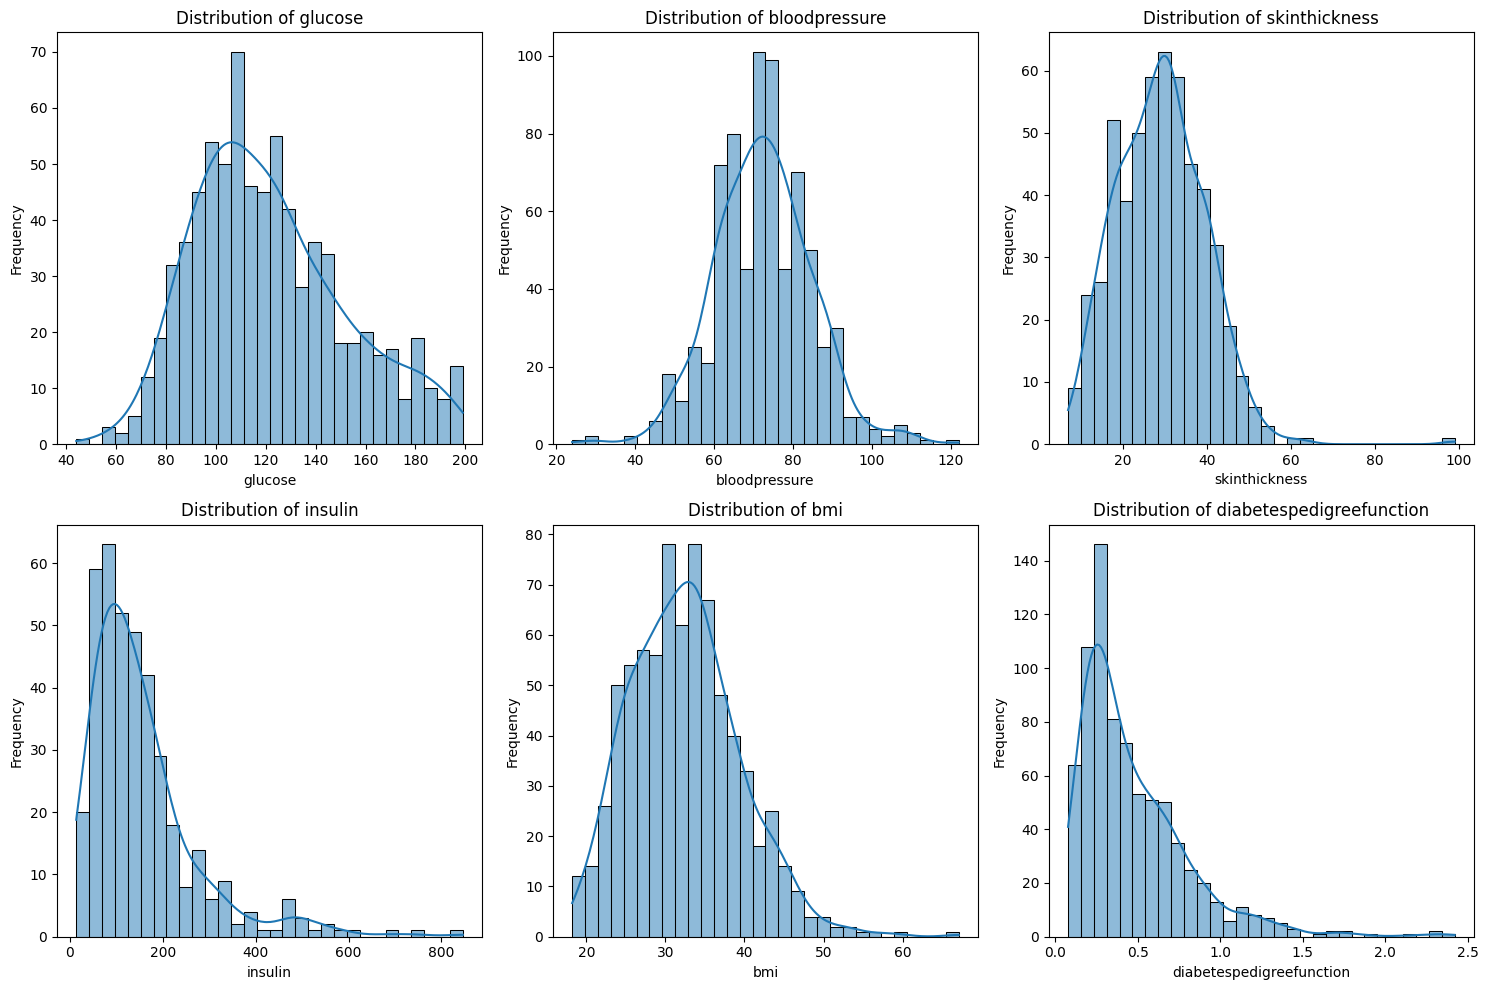

In [148]:
plot_histogram(df, float_features)

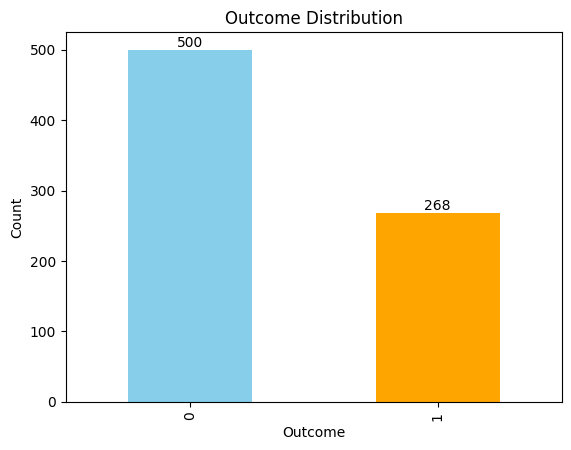

In [149]:
plot_target_distribution(df, target)

### Missing Values Imputation

In [150]:
imputer_recomender(df, float_features, soft=False, show_info=False, threshold_null=0.5)

,Column,Recommendation
0,glucose,SimpleImputer: strategy='mean'
1,bloodpressure,SimpleImputer: strategy='mean'
2,skinthickness,Iterative Imputer (Better for high correlations)
3,insulin,SimpleImputer: strategy='mean'
4,bmi,Iterative Imputer (Better for high correlations)


In [151]:
imputer = SimpleImputer(strategy='mean')

df[['glucose', "bloodpressure","insulin"]] = pd.DataFrame(imputer.fit_transform(df[['glucose', "bloodpressure","insulin"]]), columns=['glucose', "bloodpressure","insulin"])

In [152]:
iterative = IterativeImputer()

df = pd.DataFrame(iterative.fit_transform(df), columns=df.columns)

In [153]:
df[['pregnancies', "glucose","age", "outcome"]] = df[['pregnancies', "glucose","age", "outcome"]].astype(int)

### Outlier Handling

In [154]:
iqr_outliers(df, float_features, soft=False, remove=False, display_info=True)

,IQR
glucose,0
bloodpressure,14
skinthickness,4
insulin,0
bmi,8
diabetespedigreefunction,29


In [155]:
detect_all_outliers(df, float_features, remove=True)

'22 outliers removed.'

### Feature Engineering

#### Feature Selection

In [156]:
anova_krustal_categ(df, float_features, target, display_info=False)

,Impact
Feature,
glucose,True
bloodpressure,True
skinthickness,True
insulin,True
bmi,True
diabetespedigreefunction,True


All float features significantly impact the target variable; therefore, no columns are dropped.

In [157]:
mutual_info_categ(df, int_features, target, soft=True, display_info=True)

,Mutual_Info,Impact
Feature,,
pregnancies,0.012663,Low
age,0.056458,Low


In several instances, when executing the `mutual_info_categ` function, the output indicates that the impact is either low or moderate. Therefore, I will explore an alternative technique to gain more insights.

In [158]:
chi2_test_of_independence(df, int_features, target, soft=True, return_results=True)

,Chi2,P-Value,Impact
Feature,,,
age,147.068805,2.990598e-11,Very High
pregnancies,68.053002,2.182670e-08,Very High


Using this technique, the results indicate that the features have a significant impact on the target variable.

#### Feature Transformation

### Feature Encoding

### Feature Scaling

In [159]:
scaler_recommender(df, float_features, soft=True, show_info=False)

,Column,Recommendation
0,glucose,MinMaxScaler
1,bloodpressure,RobustScaler
2,skinthickness,StandardScaler
3,insulin,MinMaxScaler
4,bmi,StandardScaler
5,diabetespedigreefunction,MinMaxScaler


In [160]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

standard = StandardScaler()
minmax = MinMaxScaler()
robust = RobustScaler()

df[['skinthickness', 'bmi']] = standard.fit_transform(df[['skinthickness', 'bmi']])
df[['glucose', 'insulin', 'diabetespedigreefunction']] = minmax.fit_transform(df[['glucose', 'insulin', 'diabetespedigreefunction']])
df['bloodpressure'] = robust.fit_transform(df[['bloodpressure']])

## ML Models

In [161]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=target), df[target], test_size=0.2, random_state=42)

In [162]:
classification_metrics = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
proba_predictions_dict, predictions_dict = {}, {}

models = {
    "LogisticRegression": LogisticRegression(verbose=0),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "SVC": SVC(probability=True),
    "GaussianNB": GaussianNB(),
    "BaggingClassifier": BaggingClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "XGBClassifier": XGBClassifier(),
    "LGBMClassifier": LGBMClassifier(verbose=-1),
}

# 2. Recorre cada modelo, ajústalo y evalúalo
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    save_metrics(model, model_name, x_test, y_test, y_pred)

e:\Pima-Diabetes-Prediction\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Model Evaluation

### Classification Metrics

In [163]:
classification_metrics

,Model,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,0.753333,0.657143,0.479167,0.554217
1,KNeighborsClassifier,0.720000,0.560000,0.583333,0.571429
2,DecisionTreeClassifier,0.693333,0.517241,0.625000,0.566038
3,RandomForestClassifier,0.760000,0.642857,0.562500,0.600000
4,SVC,0.653333,0.458333,0.458333,0.458333
5,GaussianNB,0.733333,0.595238,0.520833,0.555556
6,BaggingClassifier,0.720000,0.568182,0.520833,0.543478
7,GradientBoostingClassifier,0.800000,0.687500,0.687500,0.687500
8,AdaBoostClassifier,0.773333,0.675000,0.562500,0.613636
9,XGBClassifier,0.760000,0.620000,0.645833,0.632653


### Confusion Matrix

In [164]:
y_test.value_counts()

outcome
0    102
1     48
Name: count, dtype: int64

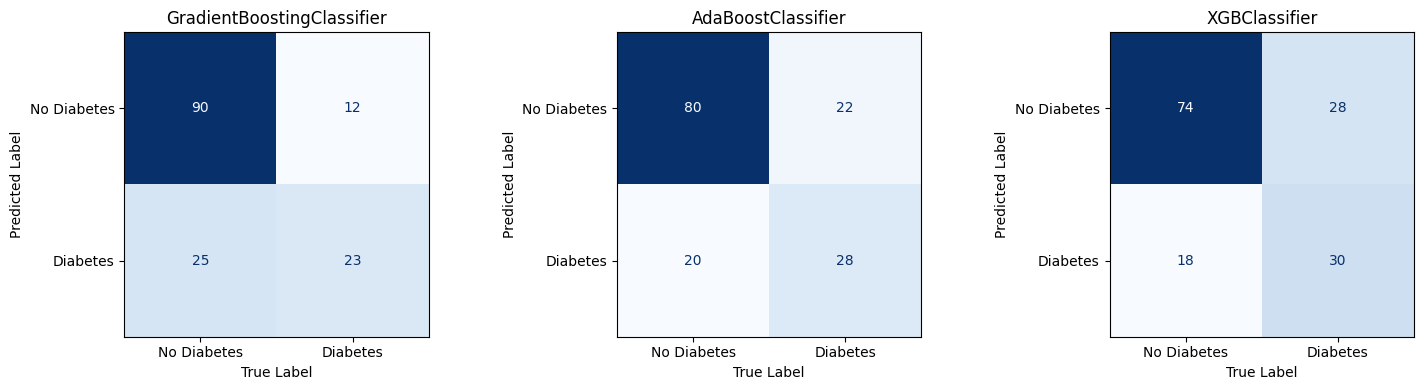

In [165]:
display_confusion_matrix(proba_predictions_dict,models = ['GradientBoostingClassifier', "AdaBoostClassifier", "XGBClassifier"] ,labels=['No Diabetes', 'Diabetes'], cmap='Blues', models_per_row=4)

### ROC Curve

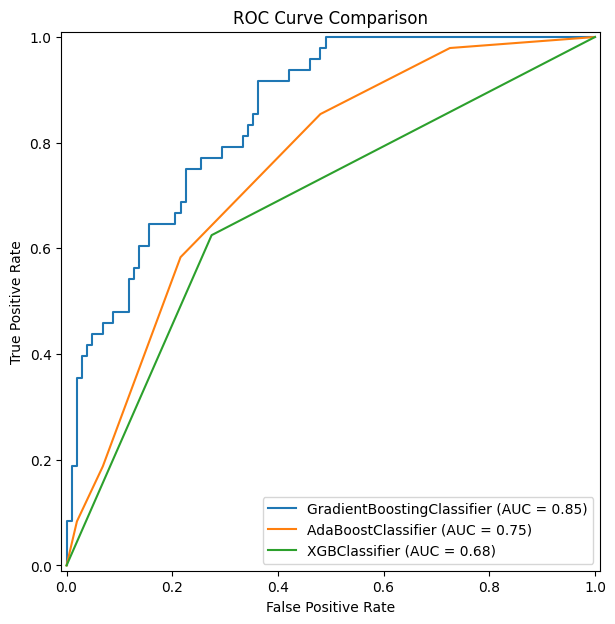

In [166]:
display_roc_curves(proba_predictions_dict, models=['GradientBoostingClassifier', "AdaBoostClassifier", "XGBClassifier"])

### Precision-Recall Curve

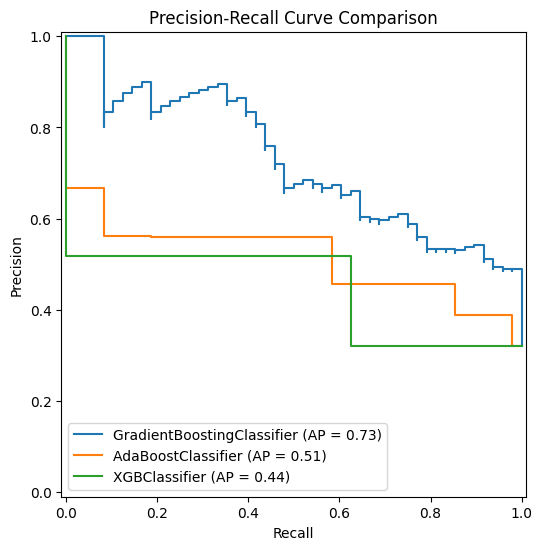

In [167]:
display_precision_recall_curve(proba_predictions_dict, models=['GradientBoostingClassifier', "AdaBoostClassifier", "XGBClassifier"])

## Model Validation

### K-Fold Validation

e:\Pima-Diabetes-Prediction\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\Pima-Diabetes-Prediction\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

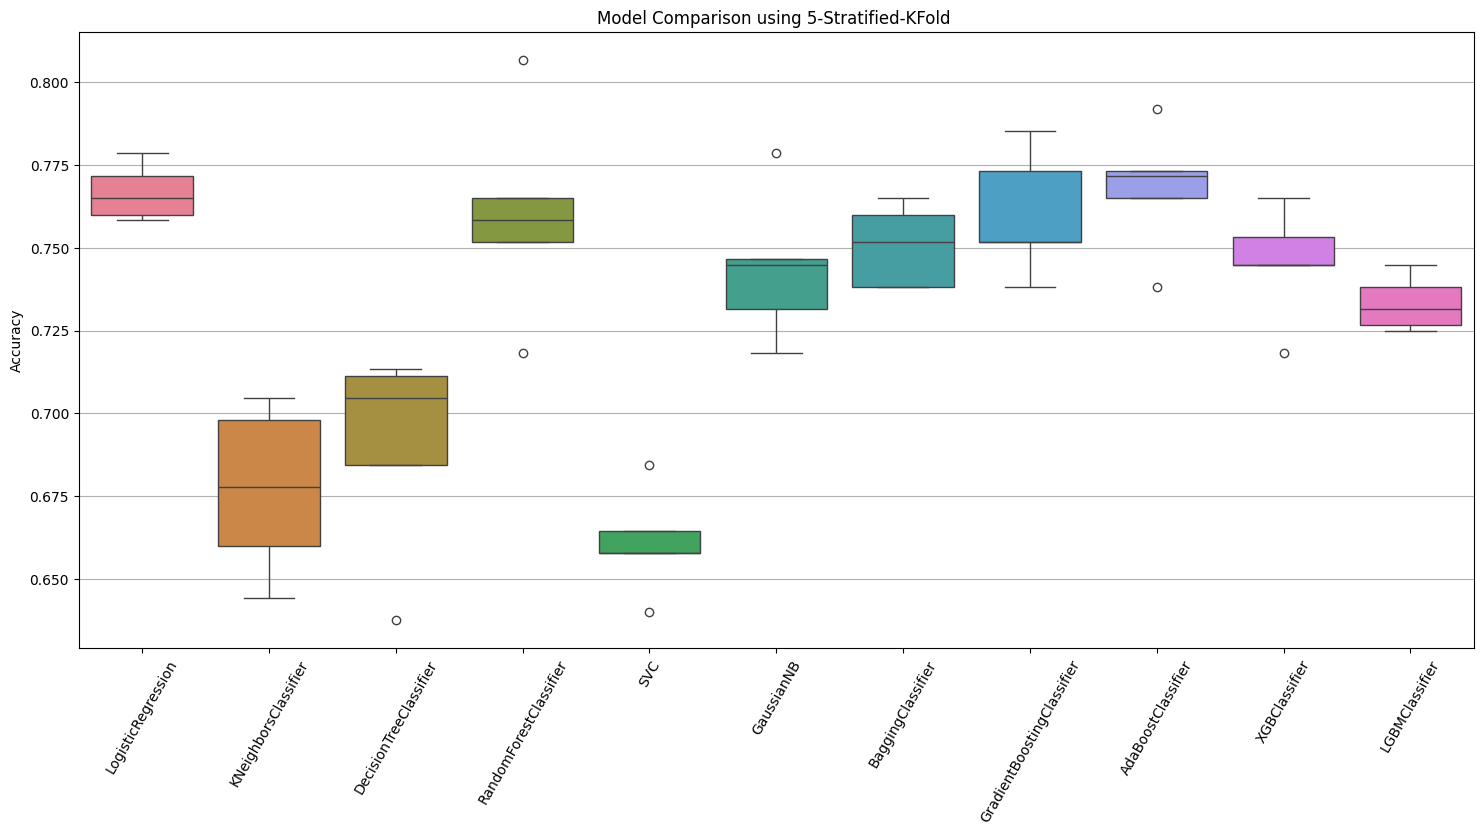

In [168]:
evaluate_models_with_kfold(models, df.drop(columns=target), df[target], cv=5, scoring='accuracy')

### Learning Curve

e:\Pima-Diabetes-Prediction\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\Pima-Diabetes-Prediction\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

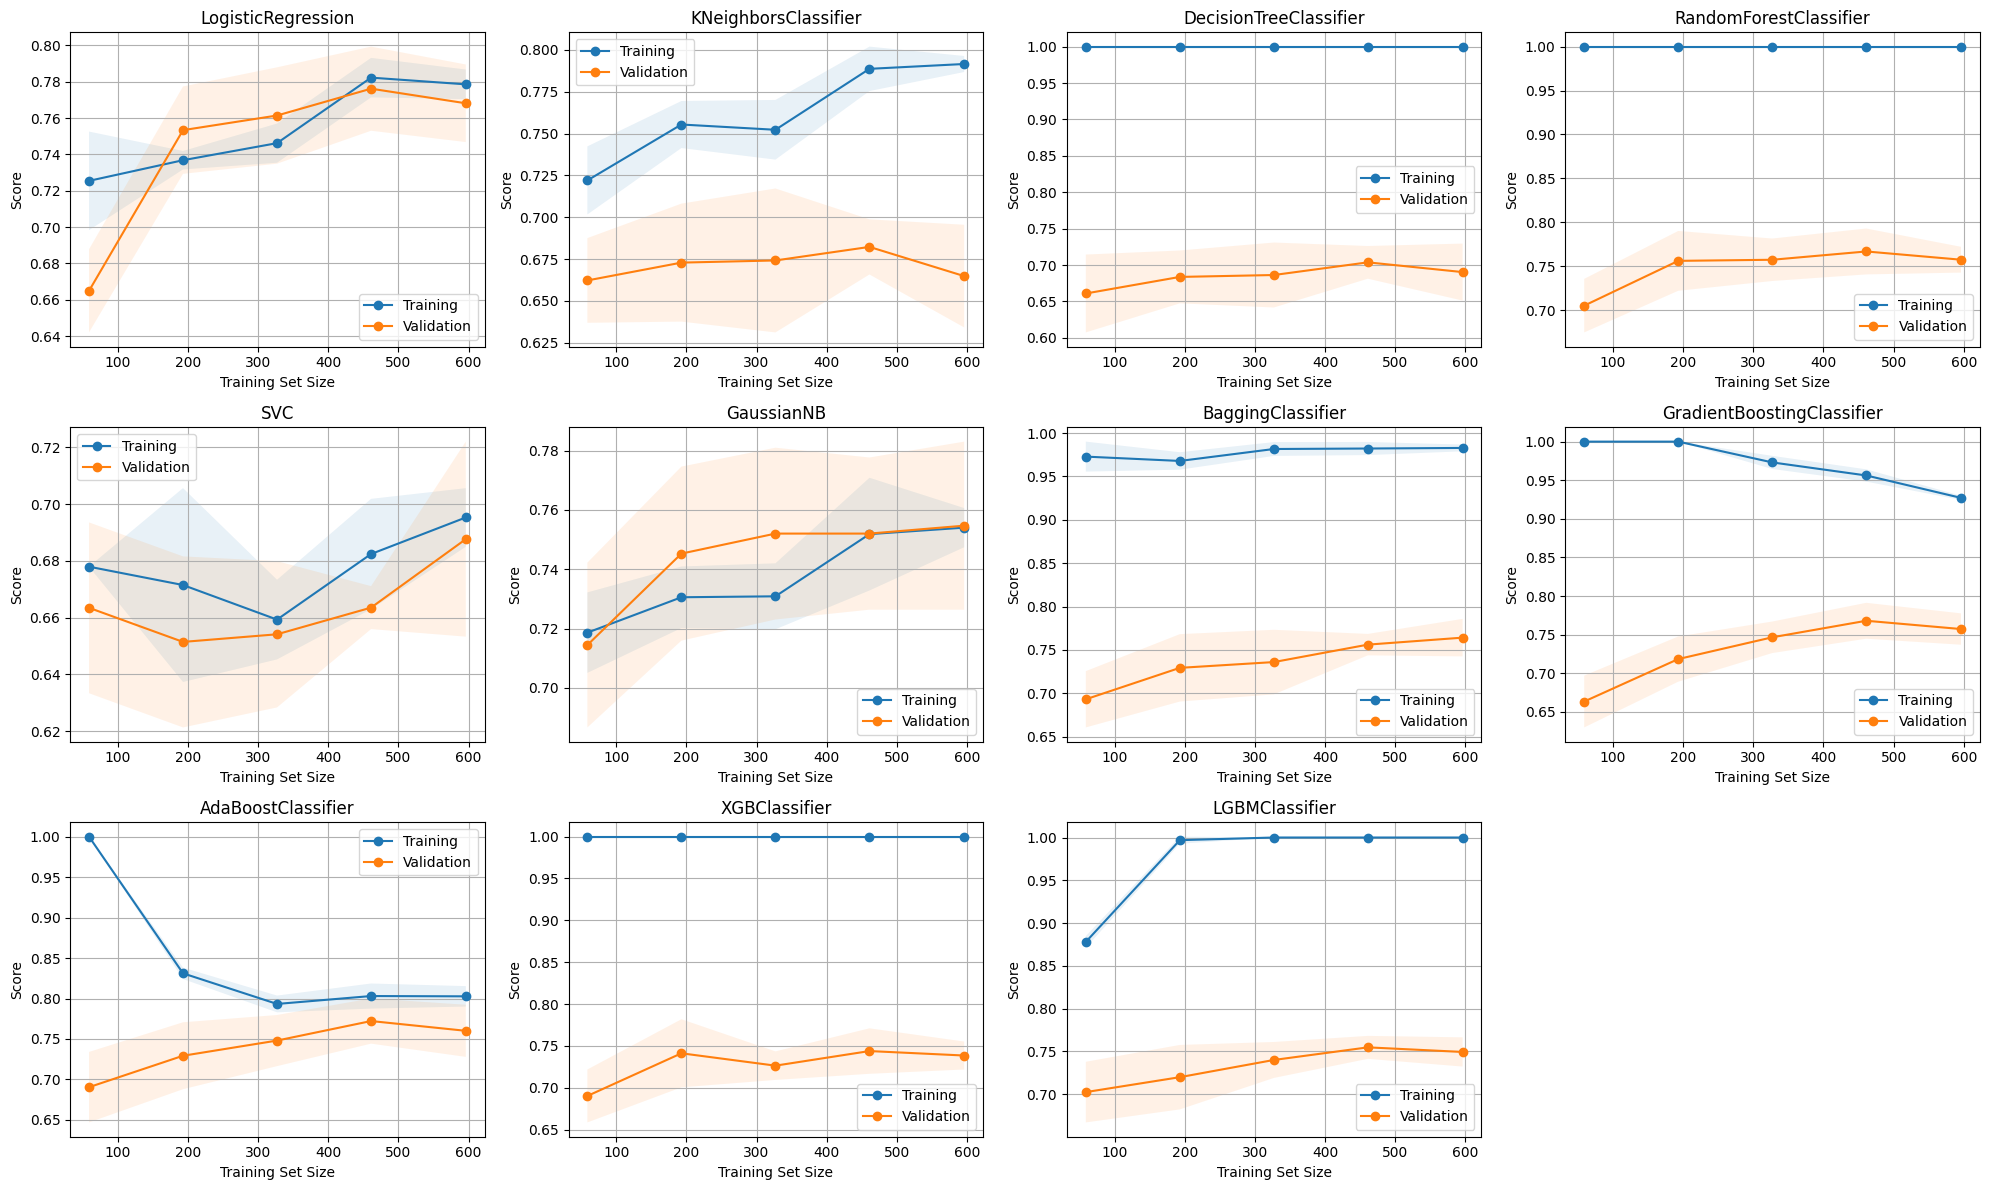

In [169]:
plot_learning_curves(models, df.drop(columns=target), df[target], cv=5, scoring='accuracy', n_jobs=1)

## Model Optimization

### Hyperparameter Tuning

In [170]:
param_grids = {
    "LogisticRegression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "penalty": ["l2"],
        "solver": ["lbfgs", "liblinear"],
        "max_iter": [100, 200]
    },
    "KNeighborsClassifier": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    },
    "DecisionTreeClassifier": {
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    "RandomForestClassifier": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "bootstrap": [True, False]
    },
    "SVC": {
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", "auto"],
        "kernel": ["rbf", "poly"],
        "degree": [2, 3]  # solo si kernel = poly
    },
    "GaussianNB": {
        "var_smoothing": [1e-9, 1e-8, 1e-7]
    },
    "BaggingClassifier": {
        "n_estimators": [10, 50, 100],
        "max_samples": [0.5, 0.75, 1.0],
        "max_features": [0.5, 1.0],
        "bootstrap": [True, False]
    },
    "GradientBoostingClassifier": {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 1.0]
    },
    "AdaBoostClassifier": {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.5, 1.0, 1.5]
    },
    "XGBClassifier": {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "LGBMClassifier": {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.01, 0.05, 0.1],
        "num_leaves": [15, 31, 63],
        "boosting_type": ["gbdt", "dart"],
        "feature_fraction": [0.8, 1.0]
    }
}


### Model Validation